In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import keras

import bayesflow as bf

## Setup

In [3]:
two_moons = bf.benchmarks.TwoMoons()

In [4]:
num_train_simulations = 2048
num_val_simulations = 300
batch_size = 256
epochs = 10

In [5]:
train_dataset = bf.datasets.OfflineDataset(two_moons.sample(num_train_simulations), batch_size=batch_size)
val_dataset = bf.datasets.OfflineDataset(two_moons.sample(num_val_simulations), batch_size=100)

In [6]:
inference_network = bf.networks.CouplingFlow(depth=5)

approximator = bf.Approximator(
    inference_network=inference_network,
    inference_variables=["parameters"],
    inference_conditions=["observables"],
)

In [7]:
learning_rate = keras.optimizers.schedules.CosineDecay(1e-3, epochs * train_dataset.num_batches, 1e-6)

optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate,
    global_clipnorm=1.0,
)

In [8]:
approximator.compile(optimizer=optimizer)

## Training

In [9]:
fit_history = approximator.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 0.8138 - val_loss: -0.3129
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: -0.4305 - val_loss: -0.6916
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: -0.6789 - val_loss: -0.7908
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: -1.0023 - val_loss: -1.1958
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: -1.2214 - val_loss: -1.3746
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: -1.5546 - val_loss: -1.6660
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: -1.8089 - val_loss: -1.8302
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: -1.9711 - val_loss: -2.0118
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: -2.1345 - val_loss: -2.0694
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: -2.1845 - val_loss: -2.0792


In [10]:
## Plot losses

## Validation

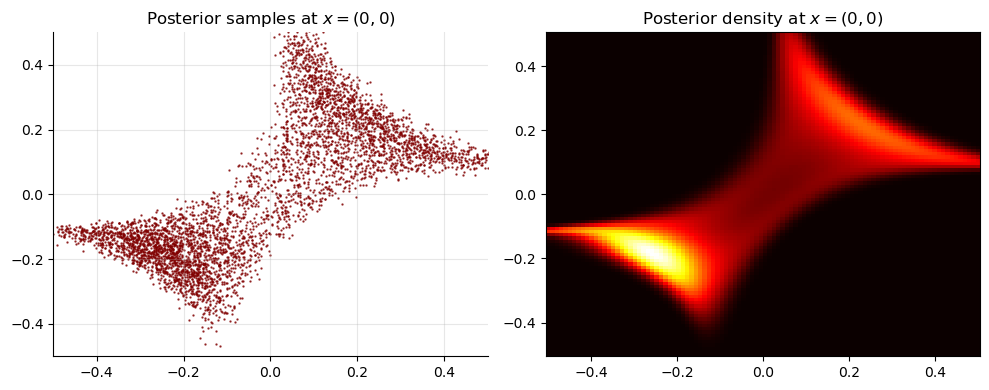

In [12]:
# Set the number of posterior draws you want to get
num_samples = 5000

# Prepare figure
f, axarr = plt.subplots(1, 2, figsize=(10, 4))

# Obtain amortized samples
obs_data = np.zeros((1, 2)).astype(np.float32)
samples = approximator.sample(num_samples=num_samples, data={"observables": obs_data}, numpy=True)

# Plot samples
axarr[0].scatter(samples["parameters"][:, 0], samples["parameters"][:, 1], color="maroon", alpha=0.75, s=0.5)
sns.despine(ax=axarr[0])
axarr[0].set_title(r"Posterior samples at $x=(0, 0)$")
axarr[0].grid(alpha=0.3)
axarr[0].set_xlim([-0.5, 0.5])
axarr[0].set_ylim([-0.5, 0.5])

# Compute log density on relevant posterior range
side = np.linspace(-0.5, 0.5, 100)
x, y = np.meshgrid(side, side)
obs_data_rep = np.zeros((10000, 2)).astype(np.float32)
params = np.c_[x.flatten(), y.flatten()]
lpdf = inference_network.log_prob(params, obs_data_rep)

# # Plot the density map using nearest-neighbor interpolation
axarr[1].pcolormesh(x, y, np.exp(lpdf).reshape(100, 100), cmap=cm.hot)
axarr[1].set_title(r"Posterior density at $x=(0, 0)$")

f.tight_layout()